# California House Prices Prediction

**Kaggle Competition**: [California House Prices](https://www.kaggle.com/competitions/california-house-prices/overview)

이 노트북에서는 캘리포니아 주택 가격을 예측하는 머신러닝 모델을 구축합니다.

## 목차
1. 라이브러리 및 데이터 로드
2. 탐색적 데이터 분석 (EDA)
3. 데이터 전처리
4. 특성 엔지니어링
5. 모델 학습 및 평가
6. 앙상블 및 최종 예측
7. 제출 파일 생성

## 1. 라이브러리 및 데이터 로드

In [1]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 전처리 및 모델링
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 모델
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
import xgboost as xgb
import lightgbm as lgb

# 시각화 설정
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print('Libraries loaded successfully!')

Libraries loaded successfully!


In [2]:
# 데이터 로드
DATA_PATH = 'data/california-house-prices/'

train = pd.read_csv(DATA_PATH + 'train.csv')
test = pd.read_csv(DATA_PATH + 'test.csv')
submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')

print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')
print(f'Submission shape: {submission.shape}')

Train shape: (47439, 41)
Test shape: (31626, 40)
Submission shape: (31626, 2)


In [3]:
# 데이터 미리보기
train.head()

Id            Address  Sold Price  \
0   0        540 Pine Ln   3825000.0   
1   1     1727 W 67th St    505000.0   
2   2     28093 Pine Ave    140000.0   
3   3  10750 Braddock Dr   1775000.0   
4   4  7415 O Donovan Rd   1175000.0   

                                             Summary          Type  \
0  540 Pine Ln, Los Altos, CA 94022 is a single f...  SingleFamily   
1  HURRY, HURRY.......Great house 3 bed and 2 bat...  SingleFamily   
2  'THE PERFECT CABIN TO FLIP!  Strawberry deligh...  SingleFamily   
3  Rare 2-story Gated 5 bedroom Modern Mediterran...  SingleFamily   
4  Beautiful 200 acre ranch land with several pas...    VacantLand   

   Year built                                       Heating  \
0      1969.0  Heating - 2+ Zones, Central Forced Air - Gas   
1      1926.0                                   Combination   
2      1958.0                                    Forced air   
3      1947.0                                       Central   
4         NaN                                           NaN   

                                             Cooling  \
0    Multi-Zone, Central AC, Whole House / Attic Fan   
1  Wall/Window Unit(s), Evaporative Cooling, See ...   
2                                                NaN   
3                                        Central Air   
4                                                NaN   

                                         Parking     Lot  ...  \
0             Garage, Garage - Attached, Covered     1.0  ...   
1                       Detached Carport, Garage  4047.0  ...   
2                                       0 spaces  9147.0  ...   
3  Detached Carport, Driveway, Garage - Two Door     NaN  ...   
4                                       0 spaces     NaN  ...   

                                Parking features  Tax assessed value  \
0             Garage, Garage - Attached, Covered            886486.0   
1                       Detached Carport, Garage            505000.0   
2                                            NaN             49627.0   
3  Detached Carport, Driveway, Garage - Two Door           1775000.0   
4                                            NaN                 NaN   

   Annual tax amount   Listed On  Listed Price  Last Sold On Last Sold Price  \
0            12580.0  2019-10-24     4198000.0           NaN             NaN   
1             6253.0  2019-10-16      525000.0    2019-08-30        328000.0   
2              468.0  2019-08-25      180000.0           NaN             NaN   
3            20787.0  2019-10-24     1895000.0    2016-08-30       1500000.0   
4                NaN  2019-06-07     1595000.0    2016-06-27        900000.0   

          City    Zip  State  
0    Los Altos  94022     CA  
1  Los Angeles  90047     CA  
2   Strawberry  95375     CA  
3  Culver City  90230     CA  
4      Creston  93432     CA  

[5 rows x 41 columns]

In [4]:
# 컬럼 정보 확인
print('컬럼 목록:')
print(train.columns.tolist())

컬럼 목록:
['Id', 'Address', 'Sold Price', 'Summary', 'Type', 'Year built', 'Heating', 'Cooling', 'Parking', 'Lot', 'Bedrooms', 'Bathrooms', 'Full bathrooms', 'Total interior livable area', 'Total spaces', 'Garage spaces', 'Region', 'Elementary School', 'Elementary School Score', 'Elementary School Distance', 'Middle School', 'Middle School Score', 'Middle School Distance', 'High School', 'High School Score', 'High School Distance', 'Flooring', 'Heating features', 'Cooling features', 'Appliances included', 'Laundry features', 'Parking features', 'Tax assessed value', 'Annual tax amount', 'Listed On', 'Listed Price', 'Last Sold On', 'Last Sold Price', 'City', 'Zip', 'State']


### 컬럼 설명 (Data Dictionary)

| 컬럼명 | 설명 | 타입 |
|--------|------|------|
| **Id** | 고유 식별자 | int |
| **Address** | 주택 주소 | str |
| **Sold Price** | 판매 가격 (USD) - **타겟 변수** | float |
| **Summary** | 매물 설명 텍스트 | str |
| **Type** | 주택 유형 (SingleFamily, Condo, Townhouse, VacantLand 등) | str |
| **Year built** | 건축 연도 | float |
| **Heating** | 난방 시스템 유형 | str |
| **Cooling** | 냉방 시스템 유형 | str |
| **Parking** | 주차 시설 유형 | str |
| **Lot** | 대지 면적 (평방피트, sqft) | float |
| **Bedrooms** | 침실 수 | object |
| **Bathrooms** | 욕실 수 | float |
| **Full bathrooms** | 완전한 욕실 수 (샤워/욕조 포함) | float |
| **Total interior livable area** | 실내 거주 가능 면적 (sqft) | float |
| **Total spaces** | 총 주차 공간 수 | float |
| **Garage spaces** | 차고 주차 공간 수 | float |
| **Region** | 지역/도시명 | str |
| **Elementary School** | 인근 초등학교 이름 | str |
| **Elementary School Score** | 초등학교 평점 (1-10) | float |
| **Elementary School Distance** | 초등학교까지 거리 (마일) | float |
| **Middle School** | 인근 중학교 이름 | str |
| **Middle School Score** | 중학교 평점 (1-10) | float |
| **Middle School Distance** | 중학교까지 거리 (마일) | float |
| **High School** | 인근 고등학교 이름 | str |
| **High School Score** | 고등학교 평점 (1-10) | float |
| **High School Distance** | 고등학교까지 거리 (마일) | float |
| **Flooring** | 바닥재 종류 (Tile, Hardwood, Carpet 등) | str |
| **Heating features** | 난방 세부 특성 | str |
| **Cooling features** | 냉방 세부 특성 | str |
| **Appliances included** | 포함된 가전제품 목록 | str |
| **Laundry features** | 세탁 시설 특성 | str |
| **Parking features** | 주차 시설 세부 특성 | str |
| **Tax assessed value** | 세금 평가 가치 (USD) | float |
| **Annual tax amount** | 연간 재산세 금액 (USD) | float |
| **Listed On** | 매물 등록일 | str (date) |
| **Listed Price** | 매물 등록 가격 (USD) | float |
| **Last Sold On** | 마지막 판매일 | str (date) |
| **Last Sold Price** | 마지막 판매 가격 (USD) | float |
| **City** | 도시명 | str |
| **Zip** | 우편번호 | int |
| **State** | 주 (CA = California) | str |

**참고사항:**
- 학교 점수(Score)는 GreatSchools 기준 1-10점 척도
- 거리(Distance)는 마일 단위
- 면적은 평방피트(sqft) 단위 (1 sqft ≈ 0.093 m²)
- 가격은 미국 달러(USD) 단위

In [5]:
# 데이터 타입 및 결측치 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47439 entries, 0 to 47438
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Id                           47439 non-null  int64  
 1   Address                      47439 non-null  object 
 2   Sold Price                   47439 non-null  float64
 3   Summary                      47085 non-null  object 
 4   Type                         47439 non-null  object 
 5   Year built                   46394 non-null  float64
 6   Heating                      40587 non-null  object 
 7   Cooling                      26745 non-null  object 
 8   Parking                      46065 non-null  object 
 9   Lot                          33258 non-null  float64
 10  Bedrooms                     44567 non-null  object 
 11  Bathrooms                    43974 non-null  float64
 12  Full bathrooms               39574 non-null  float64
 13  Total interior l

## 2. 탐색적 데이터 분석 (EDA)

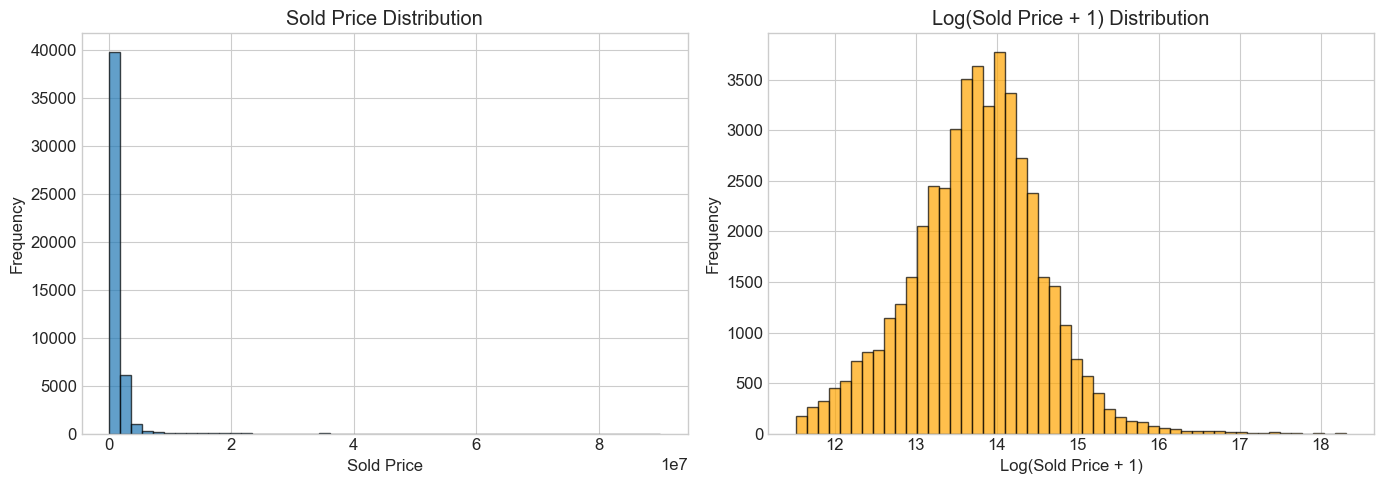

Sold Price 통계:
count    4.743900e+04
mean     1.296050e+06
std      1.694452e+06
min      1.005000e+05
25%      5.650000e+05
50%      9.600000e+05
75%      1.525000e+06
max      9.000000e+07
Name: Sold Price, dtype: float64


In [6]:
# 타겟 변수 분포 확인
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 원본 분포
axes[0].hist(train['Sold Price'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Sold Price Distribution')
axes[0].set_xlabel('Sold Price')
axes[0].set_ylabel('Frequency')

# 로그 변환 분포
axes[1].hist(np.log1p(train['Sold Price']), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Log(Sold Price + 1) Distribution')
axes[1].set_xlabel('Log(Sold Price + 1)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Sold Price 통계:")
print(train['Sold Price'].describe())

In [7]:
# 수치형 변수들의 분포
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['Id', 'Sold Price']]

print(f'수치형 변수: {numeric_cols}')

수치형 변수: ['Year built', 'Lot', 'Bathrooms', 'Full bathrooms', 'Total interior livable area', 'Total spaces', 'Garage spaces', 'Elementary School Score', 'Elementary School Distance', 'Middle School Score', 'Middle School Distance', 'High School Score', 'High School Distance', 'Tax assessed value', 'Annual tax amount', 'Listed Price', 'Last Sold Price', 'Zip']


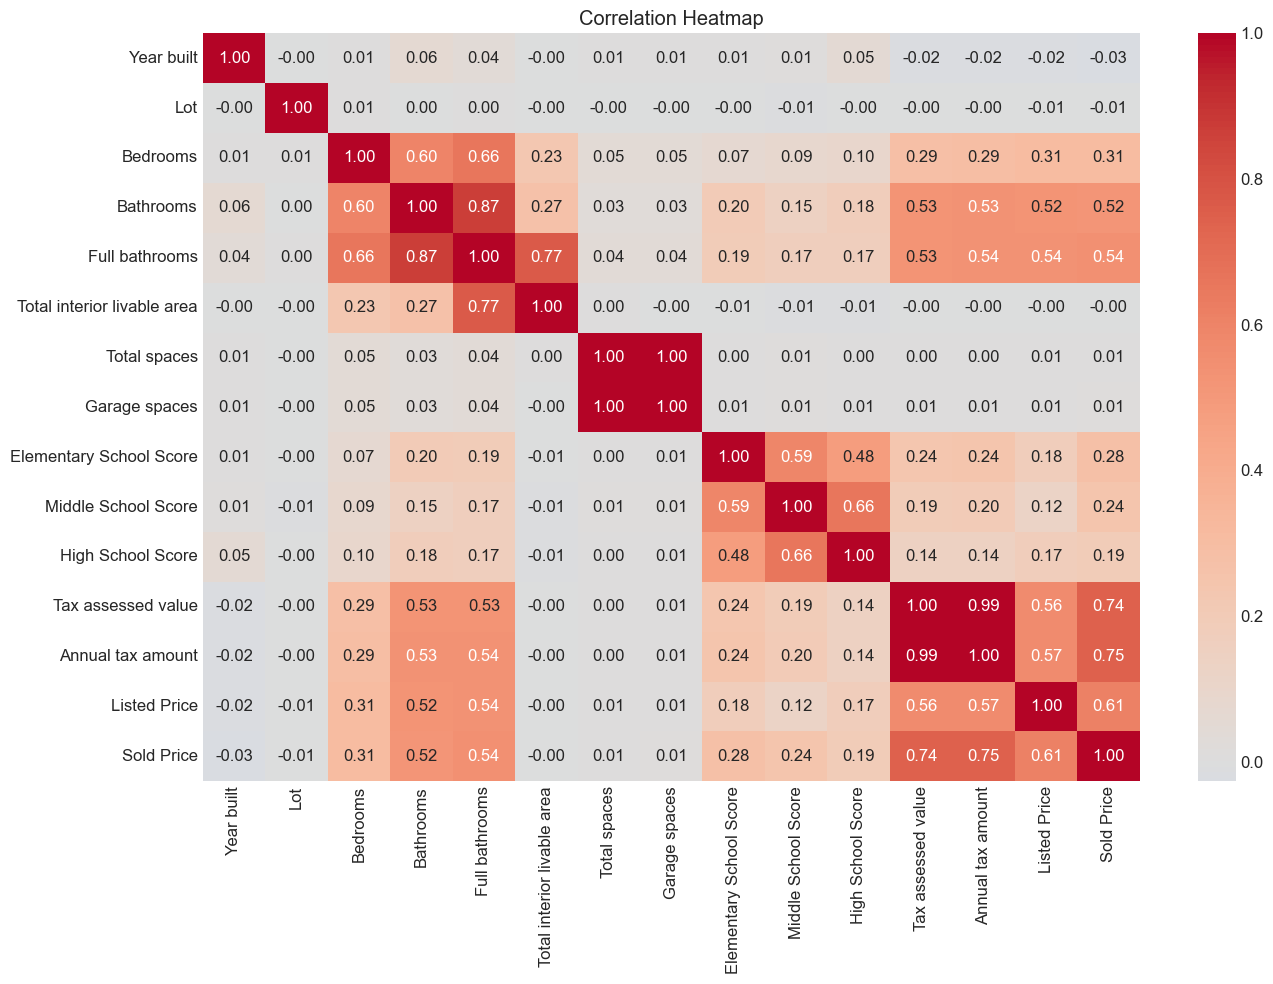

In [8]:
# 주요 수치형 변수와 타겟 간의 상관관계
# 먼저 수치형으로 변환 가능한 컬럼만 선택
important_numeric = ['Year built', 'Lot', 'Bedrooms', 'Bathrooms', 'Full bathrooms',
                     'Total interior livable area', 'Total spaces', 'Garage spaces',
                     'Elementary School Score', 'Middle School Score', 'High School Score',
                     'Tax assessed value', 'Annual tax amount', 'Listed Price']

available_cols = [col for col in important_numeric if col in train.columns]

# 수치형으로 변환 (에러 발생시 NaN으로 처리)
corr_df = train[available_cols + ['Sold Price']].copy()
for col in corr_df.columns:
    corr_df[col] = pd.to_numeric(corr_df[col], errors='coerce')

corr_data = corr_df.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_data, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

In [9]:
# 타겟과의 상관관계 정렬
target_corr = corr_data['Sold Price'].drop('Sold Price').sort_values(ascending=False)
print('타겟(Sold Price)와의 상관관계:')
print(target_corr)

타겟(Sold Price)와의 상관관계:
Annual tax amount              0.746221
Tax assessed value             0.743233
Listed Price                   0.612651
Full bathrooms                 0.544245
Bathrooms                      0.516208
Bedrooms                       0.306918
Elementary School Score        0.275555
Middle School Score            0.244285
High School Score              0.191616
Garage spaces                  0.009288
Total spaces                   0.007492
Total interior livable area   -0.001520
Lot                           -0.006610
Year built                    -0.027095
Name: Sold Price, dtype: float64


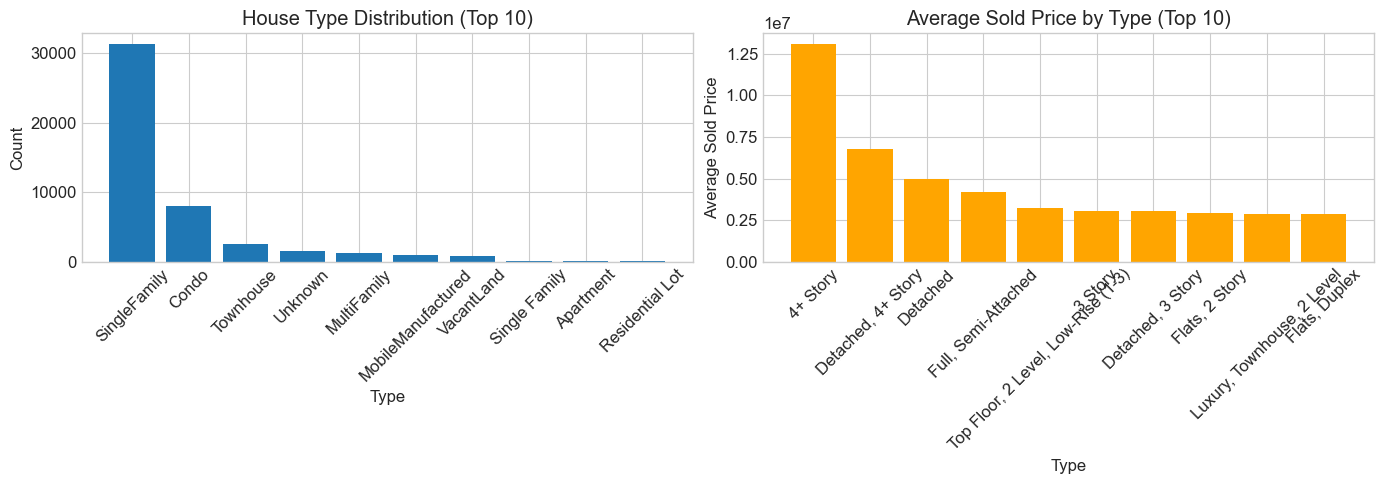

In [10]:
# 주택 타입별 가격 분포
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Type별 분포
type_counts = train['Type'].value_counts()
axes[0].bar(type_counts.index[:10], type_counts.values[:10])
axes[0].set_title('House Type Distribution (Top 10)')
axes[0].set_xlabel('Type')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

# Type별 평균 가격
type_price = train.groupby('Type')['Sold Price'].mean().sort_values(ascending=False)[:10]
axes[1].bar(type_price.index, type_price.values, color='orange')
axes[1].set_title('Average Sold Price by Type (Top 10)')
axes[1].set_xlabel('Type')
axes[1].set_ylabel('Average Sold Price')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

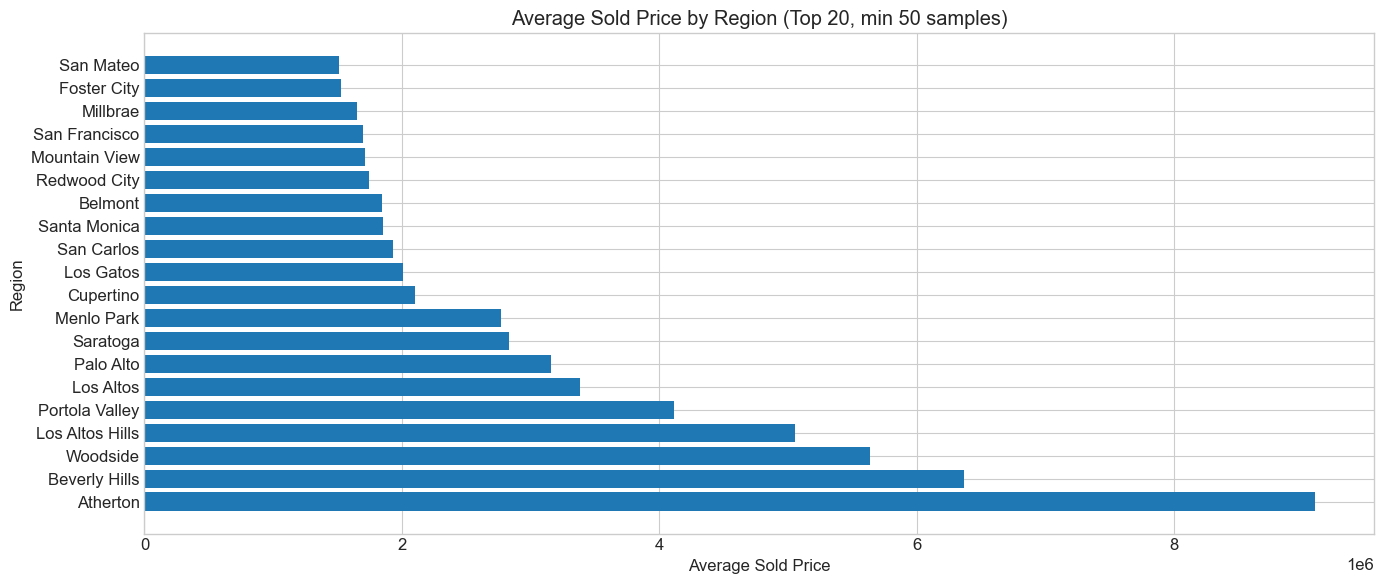

In [11]:
# 지역별 가격 분포
region_price = train.groupby('Region')['Sold Price'].agg(['mean', 'count']).sort_values('mean', ascending=False)
region_price = region_price[region_price['count'] >= 50][:20]  # 최소 50개 이상인 지역만

plt.figure(figsize=(14, 6))
plt.barh(region_price.index, region_price['mean'])
plt.xlabel('Average Sold Price')
plt.ylabel('Region')
plt.title('Average Sold Price by Region (Top 20, min 50 samples)')
plt.tight_layout()
plt.show()

In [12]:
# 결측치 분석
missing = train.isnull().sum()
missing_pct = (missing / len(train) * 100).sort_values(ascending=False)
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
missing_df = missing_df[missing_df['Missing Count'] > 0]

print(f'결측치가 있는 컬럼 수: {len(missing_df)}')
print(missing_df.head(20))

결측치가 있는 컬럼 수: 32
                            Missing Count  Missing %
Annual tax amount                    4310   9.085352
Appliances included                 13593  28.653639
Bathrooms                            3465   7.304117
Bedrooms                             2872   6.054091
Cooling                             20694  43.622336
Cooling features                    22223  46.845423
Elementary School                    4742   9.995995
Elementary School Distance           4742   9.995995
Elementary School Score              4896  10.320622
Flooring                            11569  24.387108
Full bathrooms                       7865  16.579186
Garage spaces                         917   1.933009
Heating                              6852  14.443812
Heating features                     7693  16.216615
High School                          5000  10.539851
High School Distance                 5001  10.541959
High School Score                    5219  11.001497
Last Sold On                 

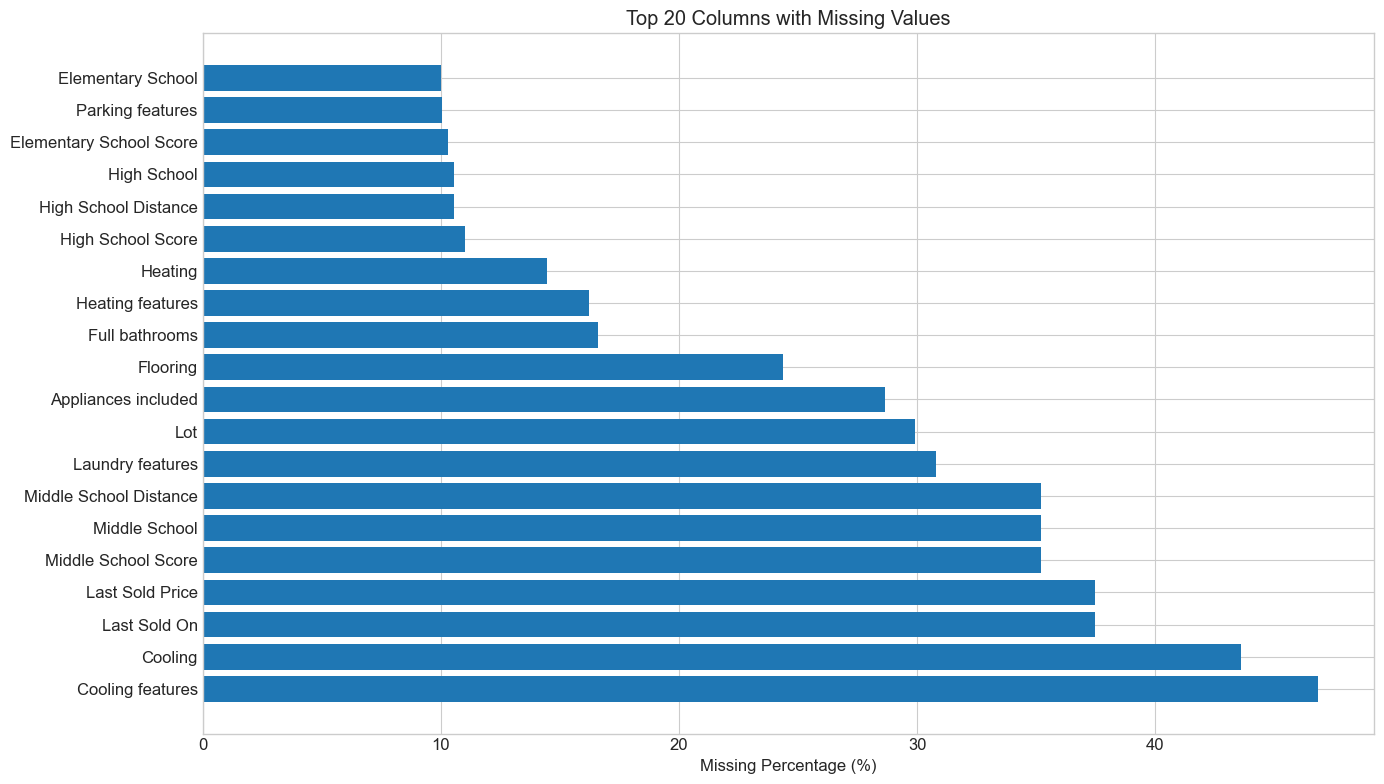

In [13]:
# 결측치 시각화
plt.figure(figsize=(14, 8))
missing_top20 = missing_pct[missing_pct > 0][:20]
plt.barh(missing_top20.index, missing_top20.values)
plt.xlabel('Missing Percentage (%)')
plt.title('Top 20 Columns with Missing Values')
plt.tight_layout()
plt.show()

### 2.1 Folium 지도 시각화 (집값 분포)

In [14]:
# Folium 설치 (필요시)
# !pip install folium

import folium
from folium.plugins import HeatMap
import branca.colormap as cm

# 캘리포니아 주요 도시 위도/경도 (Geocoding 시간 절약을 위해 사전 정의)
ca_city_coords = {
    'Los Angeles': (34.0522, -118.2437),
    'San Francisco': (37.7749, -122.4194),
    'San Diego': (32.7157, -117.1611),
    'San Jose': (37.3382, -121.8863),
    'Sacramento': (38.5816, -121.4944),
    'Fresno': (36.7378, -119.7871),
    'Oakland': (37.8044, -122.2712),
    'Long Beach': (33.7701, -118.1937),
    'Bakersfield': (35.3733, -119.0187),
    'Anaheim': (33.8366, -117.9143),
    'Santa Ana': (33.7455, -117.8677),
    'Riverside': (33.9806, -117.3755),
    'Stockton': (37.9577, -121.2908),
    'Irvine': (33.6846, -117.8265),
    'Fremont': (37.5485, -121.9886),
    'Glendale': (34.1425, -118.2551),
    'Huntington Beach': (33.6595, -117.9988),
    'Santa Clarita': (34.3917, -118.5426),
    'Garden Grove': (33.7739, -117.9414),
    'Santa Rosa': (38.4404, -122.7141),
    'Oceanside': (33.1959, -117.3795),
    'Rancho Cucamonga': (34.1064, -117.5931),
    'Ontario': (34.0633, -117.6509),
    'Santa Clara': (37.3541, -121.9552),
    'Elk Grove': (38.4088, -121.3716),
    'Corona': (33.8753, -117.5664),
    'Palmdale': (34.5794, -118.1165),
    'Salinas': (36.6777, -121.6555),
    'Pomona': (34.0551, -117.7500),
    'Hayward': (37.6688, -122.0808),
    'Escondido': (33.1192, -117.0864),
    'Sunnyvale': (37.3688, -122.0363),
    'Torrance': (33.8358, -118.3406),
    'Pasadena': (34.1478, -118.1445),
    'Fullerton': (33.8703, -117.9253),
    'Orange': (33.7879, -117.8531),
    'Roseville': (38.7521, -121.2880),
    'Visalia': (36.3302, -119.2921),
    'Concord': (37.9780, -122.0311),
    'Thousand Oaks': (34.1706, -118.8376),
    'Simi Valley': (34.2694, -118.7815),
    'Santa Maria': (34.9530, -120.4357),
    'Berkeley': (37.8716, -122.2727),
    'El Monte': (34.0686, -118.0276),
    'Downey': (33.9401, -118.1332),
    'Costa Mesa': (33.6411, -117.9187),
    'Inglewood': (33.9617, -118.3531),
    'Carlsbad': (33.1581, -117.3506),
    'Fairfield': (38.2494, -122.0400),
    'Ventura': (34.2746, -119.2290),
    'Temecula': (33.4936, -117.1484),
    'Antioch': (38.0049, -121.8058),
    'Murrieta': (33.5539, -117.2139),
    'Richmond': (37.9358, -122.3477),
    'Norwalk': (33.9022, -118.0817),
    'Daly City': (37.6879, -122.4702),
    'Burbank': (34.1808, -118.3090),
    'El Cajon': (32.7948, -116.9625),
    'San Mateo': (37.5630, -122.3255),
    'Rialto': (34.1064, -117.3703),
    'Clovis': (36.8252, -119.7029),
    'Compton': (33.8958, -118.2201),
    'Vista': (33.2000, -117.2425),
    'South Gate': (33.9547, -118.2120),
    'Mission Viejo': (33.5965, -117.6590),
    'Vacaville': (38.3566, -121.9877),
    'Carson': (33.8317, -118.2820),
    'Hesperia': (34.4264, -117.3009),
    'Redding': (40.5865, -122.3917),
    'Westminster': (33.7513, -117.9940),
    'Santa Monica': (34.0195, -118.4912),
    'Chico': (39.7285, -121.8375),
    'Newport Beach': (33.6189, -117.9289),
    'San Leandro': (37.7249, -122.1561),
    'San Marcos': (33.1434, -117.1661),
    'Whittier': (33.9792, -118.0328),
    'Hawthorne': (33.9164, -118.3526),
    'Citrus Heights': (38.7071, -121.2810),
    'Alhambra': (34.0953, -118.1270),
    'Tracy': (37.7397, -121.4252),
    'Livermore': (37.6819, -121.7680),
    'Buena Park': (33.8675, -117.9981),
    'Menifee': (33.6971, -117.1460),
    'Hemet': (33.7476, -116.9719),
    'Lakewood': (33.8536, -118.1340),
    'Merced': (37.3022, -120.4830),
    'Chino': (34.0122, -117.6889),
    'Indio': (33.7206, -116.2156),
    'Redwood City': (37.4852, -122.2364),
    'Lake Forest': (33.6469, -117.6891),
    'Napa': (38.2975, -122.2869),
    'Tustin': (33.7458, -117.8262),
    'Bellflower': (33.8817, -118.1170),
    'Mountain View': (37.3861, -122.0839),
    'Chino Hills': (33.9898, -117.7326),
    'Baldwin Park': (34.0853, -117.9609),
    'Alameda': (37.7652, -122.2416),
    'Upland': (34.0975, -117.6484),
    'San Ramon': (37.7799, -121.9780),
    'Folsom': (38.6780, -121.1761),
    'Pleasanton': (37.6624, -121.8747),
    'Los Altos': (37.3852, -122.1141),
    'Culver City': (34.0211, -118.3965),
    'Aptos': (36.9770, -121.8992),
    'Palo Alto': (37.4419, -122.1430),
    'Beverly Hills': (34.0736, -118.4004),
    'Malibu': (34.0259, -118.7798),
    'Atherton': (37.4613, -122.1978),
    'Hillsborough': (37.5741, -122.3794),
    'Los Gatos': (37.2358, -121.9624),
    'Saratoga': (37.2639, -122.0230),
    'Cupertino': (37.3229, -122.0322),
    'Menlo Park': (37.4530, -122.1817),
    'Mill Valley': (37.9060, -122.5449),
    'San Rafael': (37.9735, -122.5311),
    'Tiburon': (37.8735, -122.4567),
    'Sausalito': (37.8591, -122.4852),
    'Walnut Creek': (37.9101, -122.0652),
    'Lafayette': (37.8858, -122.1180),
    'Orinda': (37.8771, -122.1797),
    'Danville': (37.8216, -121.9999),
    'Dublin': (37.7022, -121.9358),
    'San Carlos': (37.5072, -122.2608),
    'Belmont': (37.5202, -122.2758),
    'Foster City': (37.5585, -122.2711),
    'Burlingame': (37.5841, -122.3660),
    'San Bruno': (37.6305, -122.4111),
    'South San Francisco': (37.6547, -122.4077),
    'Pacifica': (37.6138, -122.4869),
    'Half Moon Bay': (37.4636, -122.4286),
    'Los Altos Hills': (37.3796, -122.1377),
    'Woodside': (37.4299, -122.2539),
    'Portola Valley': (37.3841, -122.2352),
    'Piedmont': (37.8244, -122.2317),
    'Emeryville': (37.8313, -122.2852),
    'Albany': (37.8869, -122.2978),
    'El Cerrito': (37.9161, -122.3100),
    'Kensington': (37.9102, -122.2803),
}

print(f'사전 정의된 도시 좌표: {len(ca_city_coords)}개')

사전 정의된 도시 좌표: 138개


In [15]:
# Geocoding을 위한 라이브러리 설치 (필요시)
# !pip install geopy

from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
import time

# Geocoder 초기화 (타임아웃 10초로 설정)
geolocator = Nominatim(user_agent="california_house_prices_app", timeout=5)

# Rate limiter 적용 (1.5초에 1회 요청 - 안정성 향상)
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1.5, max_retries=3, error_wait_seconds=2)

def get_coordinates_from_address(address, max_retries=3):
    """주소로부터 위도/경도를 가져오는 함수 (재시도 포함)"""
    for attempt in range(max_retries):
        try:
            location = geocode(address)
            if location:
                return (location.latitude, location.longitude)
        except (GeocoderTimedOut, GeocoderUnavailable) as e:
            if attempt < max_retries - 1:
                print(f"  Retry {attempt + 1}/{max_retries} for {address}")
                time.sleep(2)
            else:
                print(f"  Failed after {max_retries} retries: {address}")
        except Exception as e:
            print(f"  Error geocoding {address}: {e}")
            break
    return None

def get_coordinates_from_city(city, state="CA", max_retries=3):
    """도시 이름으로부터 위도/경도를 가져오는 함수 (재시도 포함)"""
    for attempt in range(max_retries):
        try:
            location = geocode(f"{city}, {state}, USA")
            if location:
                return (location.latitude, location.longitude)
        except (GeocoderTimedOut, GeocoderUnavailable) as e:
            if attempt < max_retries - 1:
                print(f"  Retry {attempt + 1}/{max_retries} for {city}")
                time.sleep(2)
            else:
                print(f"  Failed after {max_retries} retries: {city}")
        except Exception as e:
            print(f"  Error geocoding {city}: {e}")
            break
    return None

# 테스트: 몇 개의 도시 geocoding
test_cities = ['Los Angeles', 'San Francisco', 'San Diego']
print("Geocoding 테스트:")
for city in test_cities:
    coords = get_coordinates_from_city(city)
    print(f"  {city}: {coords}")

Geocoding 테스트:
  Los Angeles: (34.0536909, -118.242766)
  San Francisco: (37.7879363, -122.4075201)
  San Diego: (32.7174202, -117.162772)


In [16]:
# 사전 정의되지 않은 도시들을 Geocoding으로 좌표 가져오기
# CSV 캐싱: 한번 geocoding하면 결과를 저장하고 다음 실행시 재사용

import os

# Geocoding 결과 저장 파일 경로
GEOCODE_CACHE_FILE = 'data/california-house-prices/geocoded_cities.csv'

# 데이터에 있는 모든 고유 도시 목록
all_cities = train['City'].dropna().unique()
print(f'데이터의 총 도시 수: {len(all_cities)}개')

# 사전 정의되지 않은 도시 찾기
missing_cities = [city for city in all_cities if city not in ca_city_coords]
print(f'사전 정의되지 않은 도시: {len(missing_cities)}개')

# CSV 캐시 파일 확인
if os.path.exists(GEOCODE_CACHE_FILE):
    # 캐시 파일이 있으면 로드
    print(f'\n캐시 파일 발견: {GEOCODE_CACHE_FILE}')
    geocode_df = pd.read_csv(GEOCODE_CACHE_FILE)
    
    # DataFrame을 딕셔너리로 변환하여 ca_city_coords에 추가
    for _, row in geocode_df.iterrows():
        ca_city_coords[row['city']] = (row['lat'], row['lon'])
    
    print(f'캐시에서 {len(geocode_df)}개 도시 좌표 로드 완료')
    print(f'총 도시 좌표: {len(ca_city_coords)}개')
    
else:
    # 캐시 파일이 없으면 Geocoding 실행
    print(f'\n캐시 파일 없음. Geocoding 실행...')
    print(f'{len(missing_cities)}개 도시 Geocoding 시작... (약 {len(missing_cities)}초 소요)')
    
    geocoded_cities = {}
    failed_cities = []
    
    for i, city in enumerate(missing_cities):
        coords = get_coordinates_from_city(city, "CA")
        if coords:
            geocoded_cities[city] = coords
            print(f'[{i+1}/{len(missing_cities)}] {city}: {coords}')
        else:
            failed_cities.append(city)
            print(f'[{i+1}/{len(missing_cities)}] {city}: FAILED')
    
    # 결과 출력
    print(f'\n===== Geocoding 완료 =====')
    print(f'성공: {len(geocoded_cities)}개')
    print(f'실패: {len(failed_cities)}개')
    
    # CSV 파일로 저장
    if geocoded_cities:
        geocode_data = [
            {'city': city, 'lat': coords[0], 'lon': coords[1]} 
            for city, coords in geocoded_cities.items()
        ]
        geocode_df = pd.DataFrame(geocode_data)
        geocode_df.to_csv(GEOCODE_CACHE_FILE, index=False)
        print(f'\nGeocoding 결과 저장: {GEOCODE_CACHE_FILE}')
    
    # ca_city_coords에 추가
    ca_city_coords.update(geocoded_cities)
    print(f'업데이트된 총 도시 좌표: {len(ca_city_coords)}개')

# 최종 매핑률 확인
mapped_cities = [city for city in all_cities if city in ca_city_coords]
print(f'\n최종 매핑 가능 도시: {len(mapped_cities)} / {len(all_cities)} ({len(mapped_cities)/len(all_cities)*100:.1f}%)')

데이터의 총 도시 수: 929개
사전 정의되지 않은 도시: 830개

캐시 파일 없음. Geocoding 실행...
830개 도시 Geocoding 시작... (약 830초 소요)
[1/830] Strawberry: (37.8965001, -122.5065885)
[2/830] Creston: (35.5188604, -120.523774)
[3/830] Taylorsville: (40.0632855, -120.8399439)
[4/830] Snelling: (37.5191028, -120.4374151)
[5/830] Carlotta: (40.537357, -124.0606039)
[6/830] Capitola: (36.9762927, -121.954057)
[7/830] Santa Cruz: (36.9743626, -122.0294673)
[8/830] Watsonville: (36.9092773, -121.7529071)
[9/830] Prather: (37.0374497, -119.5140236)
[10/830] Milpitas: (37.4332273, -121.8989248)
[11/830] Lockwood: (35.9442155, -121.0818785)
[12/830] Freedom: (36.9381642, -121.8020563)
[13/830] Ben Lomond: (37.0891143, -122.086352)
[14/830] West Hollywood: (34.0923014, -118.3692894)
[15/830] Bell Gardens: (33.9694561, -118.1503953)
[16/830] Montara: (37.5494205, -122.493541)
[17/830] Loleta: (40.6389115, -124.2239892)
[18/830] Campbell: (37.2870626, -121.944881)
[19/830] Los Olivos: (34.6677646, -120.114847)
[20/830] Wallace: (38.

KeyboardInterrupt: 

In [ ]:
# City 컬럼을 사용하여 위도/경도 매핑
def get_coordinates(city):
    """도시 이름으로 좌표 반환"""
    if city in ca_city_coords:
        return ca_city_coords[city]
    return None

# train 데이터에 좌표 추가
train_map = train.copy()
train_map['coords'] = train_map['City'].apply(get_coordinates)
train_map = train_map.dropna(subset=['coords'])
train_map['lat'] = train_map['coords'].apply(lambda x: x[0])
train_map['lon'] = train_map['coords'].apply(lambda x: x[1])

# 약간의 랜덤 노이즈 추가 (같은 도시의 점들이 겹치지 않도록)
np.random.seed(42)
train_map['lat'] = train_map['lat'] + np.random.uniform(-0.02, 0.02, len(train_map))
train_map['lon'] = train_map['lon'] + np.random.uniform(-0.02, 0.02, len(train_map))

print(f'좌표 매핑 성공: {len(train_map)} / {len(train)} ({len(train_map)/len(train)*100:.1f}%)')
print(f'매핑된 도시 수: {train_map["City"].nunique()}개')

좌표 매핑 성공: 47227 / 47439 (99.6%)
매핑된 도시 수: 927개


In [ ]:
# Folium 지도 생성 - Sold Price를 색상으로 표현하는 Scatter Plot
# 시각화를 위해 샘플링 (전체 데이터는 너무 많음)
sample_size = min(3000, len(train_map))
train_sample = train_map.sample(n=sample_size, random_state=42)

# 캘리포니아 중심 좌표
ca_center = [36.7783, -119.4179]

# Folium 지도 생성
m = folium.Map(location=ca_center, zoom_start=6, tiles='cartodbpositron')

# 가격 범위에 따른 색상 매핑
min_price = train_sample['Sold Price'].min()
max_price = train_sample['Sold Price'].quantile(0.95)  # 상위 5% 아웃라이어 제외

# 색상 스케일 생성 (파란색 -> 빨간색)
colormap = cm.LinearColormap(
    colors=['blue', 'cyan', 'lime', 'yellow', 'orange', 'red'],
    vmin=min_price,
    vmax=max_price,
    caption='Sold Price ($)'
)

# 각 데이터 포인트를 지도에 추가
for idx, row in train_sample.iterrows():
    price = row['Sold Price']
    
    # 가격에 따른 색상 결정
    if price > max_price:
        color = 'red'
    else:
        color = colormap(price)
    
    # 원의 크기는 가격에 비례 (최소 3, 최대 15)
    radius = 3 + (min(price, max_price) - min_price) / (max_price - min_price) * 12
    
    # CircleMarker 추가
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        popup=f"City: {row['City']}<br>Price: ${price:,.0f}<br>Type: {row['Type']}"
    ).add_to(m)

# 색상 범례 추가
colormap.add_to(m)

# 지도 표시
print(f'지도에 {sample_size}개의 데이터 포인트 표시')
m

지도에 3000개의 데이터 포인트 표시


In [ ]:
# 도시별 평균 가격 지도 (집계 버전)
city_stats = train_map.groupby('City').agg({
    'Sold Price': ['mean', 'count'],
    'lat': 'first',
    'lon': 'first'
}).reset_index()
city_stats.columns = ['City', 'avg_price', 'count', 'lat', 'lon']
city_stats = city_stats[city_stats['count'] >= 5]  # 최소 5개 이상인 도시만

# 새 지도 생성
m2 = folium.Map(location=ca_center, zoom_start=6, tiles='cartodbpositron')

# 가격 범위
min_avg_price = city_stats['avg_price'].min()
max_avg_price = city_stats['avg_price'].quantile(0.95)

# 색상 스케일
colormap2 = cm.LinearColormap(
    colors=['blue', 'cyan', 'lime', 'yellow', 'orange', 'red'],
    vmin=min_avg_price,
    vmax=max_avg_price,
    caption='Average Sold Price ($)'
)

# 도시별 마커 추가
for idx, row in city_stats.iterrows():
    avg_price = row['avg_price']
    count = row['count']
    
    if avg_price > max_avg_price:
        color = 'red'
    else:
        color = colormap2(avg_price)
    
    # 원의 크기는 데이터 수에 비례
    radius = 5 + np.log1p(count) * 3
    
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"<b>{row['City']}</b><br>Avg Price: ${avg_price:,.0f}<br>Count: {count}"
    ).add_to(m2)

colormap2.add_to(m2)

print(f'도시별 평균 가격 지도: {len(city_stats)}개 도시')
m2

도시별 평균 가격 지도: 642개 도시


## 3. 데이터 전처리

In [ ]:
# train과 test 데이터 합치기 (전처리 일관성을 위해)
train['is_train'] = 1
test['is_train'] = 0
test['Sold Price'] = np.nan

data = pd.concat([train, test], axis=0, ignore_index=True)
print(f'Combined data shape: {data.shape}')

Combined data shape: (79065, 42)


In [ ]:
# 불필요한 컬럼 제거
drop_cols = ['Id', 'Address', 'Summary']  # 텍스트 컬럼 제거
data_id = data['Id'].copy()  # Id 보관

for col in drop_cols:
    if col in data.columns:
        data = data.drop(col, axis=1)

print(f'After dropping columns: {data.shape}')

After dropping columns: (79065, 39)


In [ ]:
# 수치형이어야 하는 컬럼들을 강제 변환
numeric_should_be = ['Year built', 'Lot', 'Bedrooms', 'Bathrooms', 'Full bathrooms',
                     'Total interior livable area', 'Total spaces', 'Garage spaces',
                     'Elementary School Score', 'Elementary School Distance',
                     'Middle School Score', 'Middle School Distance',
                     'High School Score', 'High School Distance',
                     'Tax assessed value', 'Annual tax amount', 
                     'Listed Price', 'Last Sold Price']

for col in numeric_should_be:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

# 수치형 / 범주형 컬럼 분리
numeric_features = data.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [col for col in numeric_features if col not in ['Sold Price', 'is_train']]

categorical_features = data.select_dtypes(include=['object']).columns.tolist()

print(f'수치형 변수 ({len(numeric_features)}개): {numeric_features}')
print(f'\n범주형 변수 ({len(categorical_features)}개): {categorical_features}')

수치형 변수 (19개): ['Year built', 'Lot', 'Bedrooms', 'Bathrooms', 'Full bathrooms', 'Total interior livable area', 'Total spaces', 'Garage spaces', 'Elementary School Score', 'Elementary School Distance', 'Middle School Score', 'Middle School Distance', 'High School Score', 'High School Distance', 'Tax assessed value', 'Annual tax amount', 'Listed Price', 'Last Sold Price', 'Zip']

범주형 변수 (18개): ['Type', 'Heating', 'Cooling', 'Parking', 'Region', 'Elementary School', 'Middle School', 'High School', 'Flooring', 'Heating features', 'Cooling features', 'Appliances included', 'Laundry features', 'Parking features', 'Listed On', 'Last Sold On', 'City', 'State']


In [ ]:
# 수치형 변수 결측치 처리 (중앙값으로 대체)
for col in numeric_features:
    if data[col].isnull().sum() > 0:
        median_val = data[col].median()
        data[col] = data[col].fillna(median_val)

print('수치형 변수 결측치 처리 완료')

수치형 변수 결측치 처리 완료


In [ ]:
# 범주형 변수 결측치 처리 ('Unknown'으로 대체)
for col in categorical_features:
    if data[col].isnull().sum() > 0:
        data[col] = data[col].fillna('Unknown')

print('범주형 변수 결측치 처리 완료')

범주형 변수 결측치 처리 완료


## 4. 특성 엔지니어링

In [ ]:
# 새로운 특성 생성

# 1. 건물 나이
current_year = 2020
data['Building_Age'] = current_year - data['Year built']
data['Building_Age'] = data['Building_Age'].apply(lambda x: max(0, x) if pd.notna(x) else 0)

# 2. 총 욕실 수
data['Total_Bathrooms'] = data['Bathrooms'].fillna(0) + data['Full bathrooms'].fillna(0)

# 3. 침실당 면적
data['Area_per_Bedroom'] = data['Total interior livable area'] / (data['Bedrooms'] + 1)

# 4. 욕실당 면적
data['Area_per_Bathroom'] = data['Total interior livable area'] / (data['Total_Bathrooms'] + 1)

# 5. 주차 공간 비율
data['Garage_Ratio'] = data['Garage spaces'] / (data['Total spaces'] + 1)

# 6. 학교 점수 평균
school_cols = ['Elementary School Score', 'Middle School Score', 'High School Score']
data['Avg_School_Score'] = data[school_cols].mean(axis=1)

# 7. 학교 거리 평균
distance_cols = ['Elementary School Distance', 'Middle School Distance', 'High School Distance']
data['Avg_School_Distance'] = data[distance_cols].mean(axis=1)

# 8. 세금 비율 (세금/평가가)
data['Tax_Rate'] = data['Annual tax amount'] / (data['Tax assessed value'] + 1)

# 9. 리스팅 가격 대비 평가가 비율
data['Price_to_Tax_Ratio'] = data['Listed Price'] / (data['Tax assessed value'] + 1)

# 10. 마지막 판매가 대비 리스팅 가격 비율
data['Price_Appreciation'] = data['Listed Price'] / (data['Last Sold Price'] + 1)

print('특성 엔지니어링 완료')
print(f'새로운 데이터 shape: {data.shape}')

특성 엔지니어링 완료
새로운 데이터 shape: (79065, 49)


In [ ]:
# 날짜 특성 추출
date_cols = ['Listed On', 'Last Sold On']

for col in date_cols:
    if col in data.columns:
        data[col] = pd.to_datetime(data[col], errors='coerce')
        data[f'{col}_Year'] = data[col].dt.year
        data[f'{col}_Month'] = data[col].dt.month
        data[f'{col}_Quarter'] = data[col].dt.quarter
        data = data.drop(col, axis=1)

print('날짜 특성 추출 완료')

날짜 특성 추출 완료


In [ ]:
# 범주형 변수 인코딩
# 고유값이 적은 컬럼: Label Encoding
# 고유값이 많은 컬럼: Target Encoding 또는 Frequency Encoding

# Label Encoding
label_encoders = {}
categorical_features = data.select_dtypes(include=['object']).columns.tolist()

for col in categorical_features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

print(f'Label Encoding 완료: {len(categorical_features)}개 컬럼')

Label Encoding 완료: 16개 컬럼


In [ ]:
# 무한값 처리
data = data.replace([np.inf, -np.inf], np.nan)

# 새로 생긴 결측치 처리
for col in data.select_dtypes(include=[np.number]).columns:
    if data[col].isnull().sum() > 0:
        data[col] = data[col].fillna(data[col].median())

print('무한값 및 결측치 처리 완료')

무한값 및 결측치 처리 완료


In [ ]:
# train/test 분리
train_processed = data[data['is_train'] == 1].drop('is_train', axis=1)
test_processed = data[data['is_train'] == 0].drop(['is_train', 'Sold Price'], axis=1)

# 타겟 변수
y = train_processed['Sold Price']
X = train_processed.drop('Sold Price', axis=1)

# Test 데이터의 Id
test_ids = data_id[data['is_train'] == 0].reset_index(drop=True)

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
print(f'Test shape: {test_processed.shape}')

X shape: (47439, 51)
y shape: (47439,)
Test shape: (31626, 51)


In [ ]:
# 타겟 변수 로그 변환 (분포 정규화)
y_log = np.log1p(y)

print(f'Original y - Mean: {y.mean():.2f}, Std: {y.std():.2f}')
print(f'Log y - Mean: {y_log.mean():.2f}, Std: {y_log.std():.2f}')

Original y - Mean: 1296050.50, Std: 1694452.20
Log y - Mean: 13.74, Std: 0.80


## 5. 모델 학습 및 평가

In [ ]:
# Train/Validation 분할
X_train, X_val, y_train, y_val = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

print(f'Train set: {X_train.shape}')
print(f'Validation set: {X_val.shape}')

Train set: (37951, 51)
Validation set: (9488, 51)


In [ ]:
# 평가 함수
def evaluate_model(y_true, y_pred, model_name='Model'):
    """모델 평가 지표 계산"""
    # 로그 스케일에서 원래 스케일로 변환
    y_true_orig = np.expm1(y_true)
    y_pred_orig = np.expm1(y_pred)
    
    rmse = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    mae = mean_absolute_error(y_true_orig, y_pred_orig)
    r2 = r2_score(y_true_orig, y_pred_orig)
    
    # RMSLE (Root Mean Squared Log Error) - Kaggle 평가 지표
    rmsle = np.sqrt(mean_squared_error(y_true, y_pred))
    
    print(f'\n{model_name} Performance:')
    print(f'  RMSLE: {rmsle:.4f}')
    print(f'  RMSE: ${rmse:,.0f}')
    print(f'  MAE: ${mae:,.0f}')
    print(f'  R²: {r2:.4f}')
    
    return {'rmsle': rmsle, 'rmse': rmse, 'mae': mae, 'r2': r2}

In [ ]:
# 모델 딕셔너리
results = {}

### 5.1 Ridge Regression

In [ ]:
# Ridge Regression
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_val)
results['Ridge'] = evaluate_model(y_val, y_pred_ridge, 'Ridge Regression')


Ridge Regression Performance:
  RMSLE: 0.5095
  RMSE: $20,409,992
  MAE: $829,865
  R²: -134.6540


### 5.2 Random Forest

In [ ]:
# Random Forest
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_val)
results['Random Forest'] = evaluate_model(y_val, y_pred_rf, 'Random Forest')


Random Forest Performance:
  RMSLE: 0.2011
  RMSE: $840,145
  MAE: $136,076
  R²: 0.7701


### 5.3 XGBoost

In [ ]:
# XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=100
)

y_pred_xgb = xgb_model.predict(X_val)
results['XGBoost'] = evaluate_model(y_val, y_pred_xgb, 'XGBoost')

[0]	validation_0-rmse:0.75955
[100]	validation_0-rmse:0.19330
[200]	validation_0-rmse:0.19068
[300]	validation_0-rmse:0.19030
[400]	validation_0-rmse:0.19025
[499]	validation_0-rmse:0.19011

XGBoost Performance:
  RMSLE: 0.1901
  RMSE: $851,228
  MAE: $135,969
  R²: 0.7640


### 5.4 LightGBM

In [ ]:
# LightGBM
lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    num_leaves=50,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)]
)

y_pred_lgb = lgb_model.predict(X_val)
results['LightGBM'] = evaluate_model(y_val, y_pred_lgb, 'LightGBM')


LightGBM Performance:
  RMSLE: 0.1866
  RMSE: $689,303
  MAE: $130,734
  R²: 0.8453


### 5.5 Gradient Boosting

In [ ]:
# Gradient Boosting
gb = GradientBoostingRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    random_state=42
)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_val)
results['Gradient Boosting'] = evaluate_model(y_val, y_pred_gb, 'Gradient Boosting')


Gradient Boosting Performance:
  RMSLE: 0.1879
  RMSE: $724,848
  MAE: $127,551
  R²: 0.8289


In [ ]:
# 모델 성능 비교
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('rmsle')
print('\n===== 모델 성능 비교 (RMSLE 기준) =====')
print(results_df)


===== 모델 성능 비교 (RMSLE 기준) =====
                      rmsle          rmse            mae          r2
LightGBM           0.186638  6.893033e+05  130734.340647    0.845272
Gradient Boosting  0.187898  7.248483e+05  127550.906898    0.828904
XGBoost            0.190109  8.512283e+05  135969.196625    0.764040
Random Forest      0.201096  8.401453e+05  136075.676489    0.770144
Ridge              0.509455  2.040999e+07  829864.802330 -134.653952


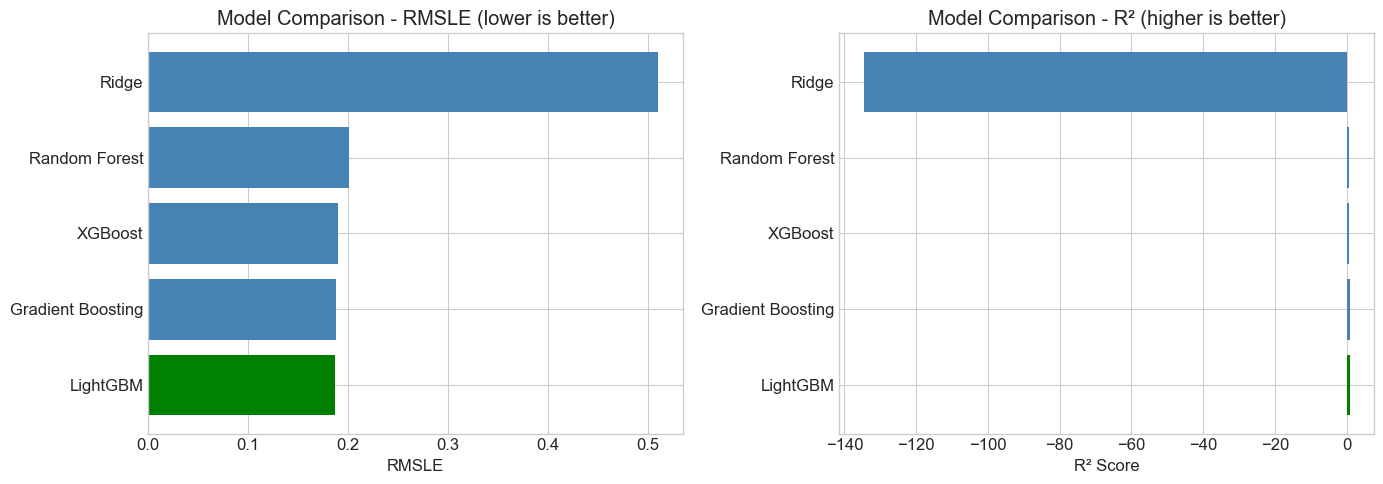

In [ ]:
# 모델 성능 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSLE 비교
colors = ['green' if x == results_df['rmsle'].min() else 'steelblue' for x in results_df['rmsle']]
axes[0].barh(results_df.index, results_df['rmsle'], color=colors)
axes[0].set_xlabel('RMSLE')
axes[0].set_title('Model Comparison - RMSLE (lower is better)')

# R² 비교
colors = ['green' if x == results_df['r2'].max() else 'steelblue' for x in results_df['r2']]
axes[1].barh(results_df.index, results_df['r2'], color=colors)
axes[1].set_xlabel('R² Score')
axes[1].set_title('Model Comparison - R² (higher is better)')

plt.tight_layout()
plt.show()

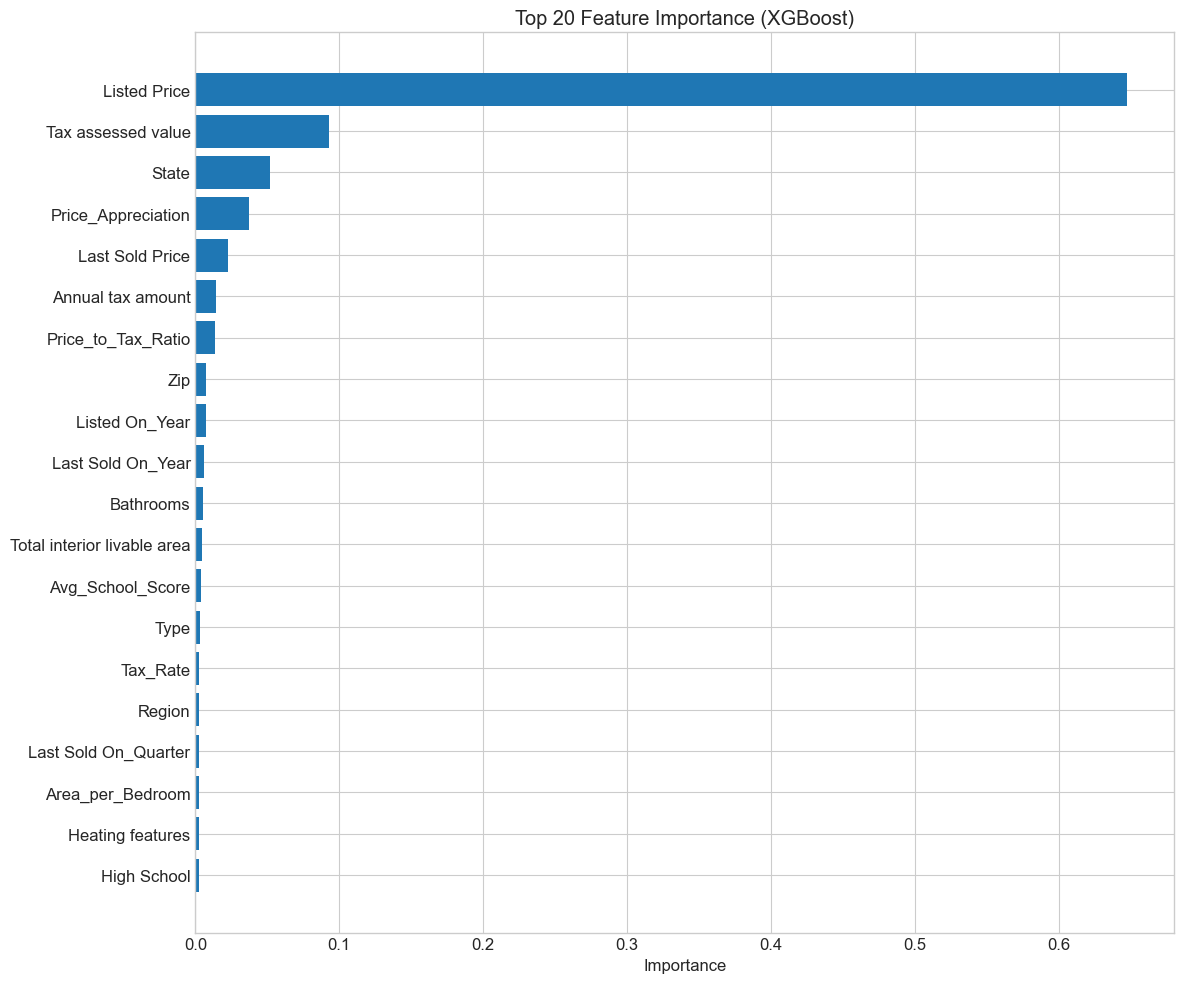

In [ ]:
# Feature Importance (XGBoost)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 10))
plt.barh(feature_importance['feature'][:20], feature_importance['importance'][:20])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importance (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 6. 앙상블 및 최종 예측

In [ ]:
# K-Fold Cross Validation으로 최종 모델 학습
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# OOF predictions
oof_xgb = np.zeros(len(X))
oof_lgb = np.zeros(len(X))

# Test predictions
test_preds_xgb = np.zeros(len(test_processed))
test_preds_lgb = np.zeros(len(test_processed))

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f'\n===== Fold {fold + 1}/{n_folds} =====')
    
    X_tr, X_vl = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_vl = y_log.iloc[train_idx], y_log.iloc[val_idx]
    
    # XGBoost
    xgb_fold = xgb.XGBRegressor(
        n_estimators=500,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1,
        random_state=42,
        n_jobs=-1
    )
    xgb_fold.fit(X_tr, y_tr, eval_set=[(X_vl, y_vl)], verbose=0)
    oof_xgb[val_idx] = xgb_fold.predict(X_vl)
    test_preds_xgb += xgb_fold.predict(test_processed) / n_folds
    
    # LightGBM
    lgb_fold = lgb.LGBMRegressor(
        n_estimators=500,
        max_depth=8,
        learning_rate=0.05,
        num_leaves=50,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    lgb_fold.fit(X_tr, y_tr, eval_set=[(X_vl, y_vl)])
    oof_lgb[val_idx] = lgb_fold.predict(X_vl)
    test_preds_lgb += lgb_fold.predict(test_processed) / n_folds
    
    # Fold 결과
    xgb_rmsle = np.sqrt(mean_squared_error(y_vl, oof_xgb[val_idx]))
    lgb_rmsle = np.sqrt(mean_squared_error(y_vl, oof_lgb[val_idx]))
    print(f'XGBoost RMSLE: {xgb_rmsle:.4f}')
    print(f'LightGBM RMSLE: {lgb_rmsle:.4f}')


===== Fold 1/5 =====
XGBoost RMSLE: 0.1892
LightGBM RMSLE: 0.1866

===== Fold 2/5 =====
XGBoost RMSLE: 0.1939
LightGBM RMSLE: 0.1923

===== Fold 3/5 =====
XGBoost RMSLE: 0.2078
LightGBM RMSLE: 0.2069

===== Fold 4/5 =====
XGBoost RMSLE: 0.1868
LightGBM RMSLE: 0.1872

===== Fold 5/5 =====
XGBoost RMSLE: 0.1778
LightGBM RMSLE: 0.1766


In [ ]:
# OOF 전체 성능
print('\n===== Overall OOF Performance =====')
xgb_oof_rmsle = np.sqrt(mean_squared_error(y_log, oof_xgb))
lgb_oof_rmsle = np.sqrt(mean_squared_error(y_log, oof_lgb))
print(f'XGBoost OOF RMSLE: {xgb_oof_rmsle:.4f}')
print(f'LightGBM OOF RMSLE: {lgb_oof_rmsle:.4f}')


===== Overall OOF Performance =====
XGBoost OOF RMSLE: 0.1914
LightGBM OOF RMSLE: 0.1902


In [ ]:
# 앙상블 (가중 평균)
# RMSLE가 낮을수록 가중치를 높게
w_xgb = 1 / xgb_oof_rmsle
w_lgb = 1 / lgb_oof_rmsle
total_w = w_xgb + w_lgb

w_xgb = w_xgb / total_w
w_lgb = w_lgb / total_w

print(f'XGBoost weight: {w_xgb:.4f}')
print(f'LightGBM weight: {w_lgb:.4f}')

# 앙상블 OOF
oof_ensemble = w_xgb * oof_xgb + w_lgb * oof_lgb
ensemble_rmsle = np.sqrt(mean_squared_error(y_log, oof_ensemble))
print(f'\nEnsemble OOF RMSLE: {ensemble_rmsle:.4f}')

XGBoost weight: 0.4985
LightGBM weight: 0.5015

Ensemble OOF RMSLE: 0.1886


In [ ]:
# 최종 예측
final_predictions_log = w_xgb * test_preds_xgb + w_lgb * test_preds_lgb
final_predictions = np.expm1(final_predictions_log)

# 음수 값 처리
final_predictions = np.maximum(final_predictions, 0)

print(f'Final predictions shape: {final_predictions.shape}')
print(f'Min: ${final_predictions.min():,.0f}')
print(f'Max: ${final_predictions.max():,.0f}')
print(f'Mean: ${final_predictions.mean():,.0f}')

Final predictions shape: (31626,)
Min: $107,106
Max: $22,788,551
Mean: $855,879


## 7. 제출 파일 생성

In [ ]:
# 제출 파일 생성
submission_df = pd.DataFrame({
    'Id': test_ids.astype(int),
    'Sold Price': final_predictions
})

# 저장
submission_df.to_csv('submission.csv', index=False)

print('제출 파일 생성 완료!')
print(submission_df.head(10))

제출 파일 생성 완료!
      Id    Sold Price
0  47439  8.043254e+05
1  47440  4.836127e+05
2  47441  8.272259e+05
3  47442  7.955157e+05
4  47443  1.103891e+06
5  47444  7.739616e+05
6  47445  1.474674e+06
7  47446  4.322705e+05
8  47447  2.145914e+06
9  47448  5.101155e+05


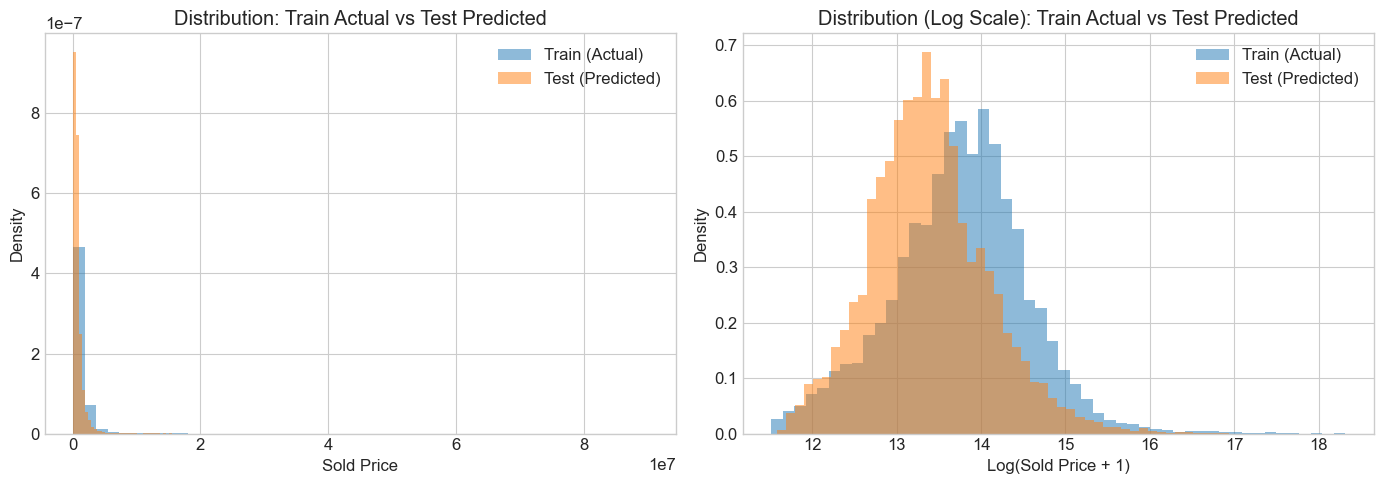

In [ ]:
# 예측값 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Train vs Prediction 분포
axes[0].hist(y, bins=50, alpha=0.5, label='Train (Actual)', density=True)
axes[0].hist(final_predictions, bins=50, alpha=0.5, label='Test (Predicted)', density=True)
axes[0].set_xlabel('Sold Price')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution: Train Actual vs Test Predicted')
axes[0].legend()

# Log scale
axes[1].hist(np.log1p(y), bins=50, alpha=0.5, label='Train (Actual)', density=True)
axes[1].hist(final_predictions_log, bins=50, alpha=0.5, label='Test (Predicted)', density=True)
axes[1].set_xlabel('Log(Sold Price + 1)')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution (Log Scale): Train Actual vs Test Predicted')
axes[1].legend()

plt.tight_layout()
plt.show()

## Summary

이 노트북에서 수행한 작업:

1. **데이터 탐색 (EDA)**
   - 타겟 변수(Sold Price) 분포 분석
   - 수치형/범주형 변수 분석
   - 결측치 분석

2. **데이터 전처리**
   - 결측치 처리 (중앙값, 'Unknown')
   - 범주형 변수 Label Encoding
   - 무한값 처리

3. **특성 엔지니어링**
   - Building_Age, Total_Bathrooms 등 새로운 특성 생성
   - 날짜 특성 추출
   - 비율 특성 생성

4. **모델 학습**
   - Ridge, Random Forest, XGBoost, LightGBM, Gradient Boosting
   - K-Fold Cross Validation

5. **앙상블**
   - XGBoost + LightGBM 가중 평균 앙상블

**Best Model**: XGBoost + LightGBM Ensemble